<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/PPOSB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stable-baselines3[extra] > /dev/null
!pip install wandb > /dev/null

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import DummyVecEnv,SubprocVecEnv,VecFrameStack
from stable_baselines3 import PPO
import wandb,os
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(repr(device))

# Load the TensorBoard notebook extension
#%load_ext tensorboard
#%tensorboard --logdir ./logsP --host 0.0.0.0
log_dir = "/content/drive/MyDrive/M/logsP/"

device(type='cuda', index=0)


In [ ]:
class TensorboardCallback(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(TensorboardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = 0 # 直近100lifeの平均スコアのベスト

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
          # スコアの検索
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          self.logger.record('timesteps', self.num_timesteps)
          self.logger.record('mean_reward', self.best_mean_reward)
          wandb.log({'mean_reward':self.best_mean_reward})
          wandb.log({'timesteps':self.num_timesteps})
          if len(x) > 0:
              # 直近100lifeのスコアの平均
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps} : ",end='')
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward/ep: {mean_reward:.2f}")

              # 直近の平均報酬が上昇した場合はモデルを保存
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)
        return True

In [ ]:
env8 = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir= log_dir)
#env8 = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, wrapper_kwargs={'clip_reward':True,'frame_skip':4}, monitor_dir= log_dir)
#env = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=8, seed=0,vec_env_cls=DummyVecEnv, wrapper_kwargs={'clip_reward':True}, monitor_dir= log_dir)
env8 = VecFrameStack(env8, n_stack=4)
callback = TensorboardCallback(check_freq=1000, log_dir=log_dir)

# 最適パラメータ https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/ppo.yml
model8 = PPO('CnnPolicy', env8, verbose=1,device=device,        
    learning_rate = 2.5e-4,  # default  3e-4
    n_steps = 128, # 2048
    clip_range = 0.1, # default 0.2
    ent_coef = 0.01, # default 0.0
    batch_size = 256, #64
    n_epochs = 4 )

total_timesteps = 1e7/10
%time model8.learn(total_timesteps=total_timesteps, callback=callback,tb_log_name="1_run")
%time model8.learn(total_timesteps=total_timesteps, callback=callback,tb_log_name="2_run", reset_num_timesteps=False)
%time model8.learn(total_timesteps=total_timesteps, callback=callback,tb_log_name="3_run", reset_num_timesteps=False)
%time model8.learn(total_timesteps=total_timesteps, callback=callback,tb_log_name="4_run", reset_num_timesteps=False)
%time model8.learn(total_timesteps=total_timesteps, callback=callback,tb_log_name="5_run", reset_num_timesteps=False)
%time model8.learn(total_timesteps=total_timesteps, callback=callback,tb_log_name="6_run", reset_num_timesteps=False)
%time model8.learn(total_timesteps=total_timesteps, callback=callback,tb_log_name="7_run", reset_num_timesteps=False)
%time model8.learn(total_timesteps=total_timesteps, callback=callback,tb_log_name="8_run", reset_num_timesteps=False)


In [ ]:
# Inside my model training code 
!export WANDB_NOTEBOOK_NAME="SB3.ipynb"
import wandb
PROJECTNAME='SB3Inv'
wandb.init(project=PROJECTNAME)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [64]:
import imageio
import numpy as np

model.load("/content/drive/MyDrive/M/logsP/SpaceInvadersBest_model")
#env8 = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir= log_dir)
env8 = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=8, seed=0,vec_env_cls=DummyVecEnv, monitor_dir= log_dir)
env8 = VecFrameStack(env8, n_stack=4)
model.set_env(env8)

images = []
obs = model.env.reset()
img = model.env.envs[0].render(mode='rgb_array')
for i in range(1800):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.envs[0].render(mode='rgb_array')

#imageio.mimsave('/SpaceInvadersBes.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

Wrapping the env in a VecTransposeImage.


In [69]:
frame_rate = 30.0  #FPS
def timelaps(images,width,height):
    
    fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
    video = cv2.VideoWriter('timelaps.mp4', fourcc, frame_rate, (width, height))
       
    print("動画変換中...")
    
    for img in images:
        video.write(img[:,:,::-1]) 
        
    
    video.release()
    print("動画変換完了")

In [67]:
timelaps(images,160,210)

動画変換中...
動画変換完了


In [39]:
!mv timelaps.mp4 drive/MyDrive/M

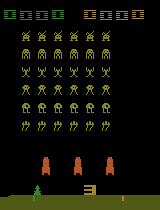

(None, 600)

In [58]:
cv2_imshow(images[0][:,:,::-1]),len(images)

In [66]:
import imageio
import numpy as np

model.load("/content/drive/MyDrive/M/logsP/SpaceInvadersBest_model")
#env8 = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir= log_dir)
env8 = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=8, seed=0,vec_env_cls=DummyVecEnv, monitor_dir= log_dir)
env8 = VecFrameStack(env8, n_stack=4)
model.set_env(env8)

images = []
obs = model.env.reset()
img = model.env.render(mode='rgb_array')[:420,:320]
for i in range(1800):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode='rgb_array')[:420,:320]

#imageio.mimsave('/SpaceInvadersBes.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

Wrapping the env in a VecTransposeImage.


In [70]:
timelaps(images,320,420)

動画変換中...
動画変換完了
